In [1]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family = 'AppleGothic')
plt.rc('axes', unicode_minus = False)
%matplotlib inline

In [3]:
data = joblib.load(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Thd_FE_v2.pkl'))

In [4]:
locals().update(data)

In [51]:
import xgboost as xgb
def MAPE(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [6]:
X.shape, y.shape

((35379, 401), (35379,))

# TimeSeries

In [49]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.03, 'colsample_bytree': 0.9, 'n_estimators' : 3000,
            'max_depth': 20, 'subsample': 0.9, 'lambda': 1. , 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear', 'gamma' : 0.01}

In [55]:
def xgb_model(X, y):
    val_preds = []
    test_preds = []
    fe_info = dict()
    for k in X.columns:
        fe_info[k] = 0

    for i in range(2, 13):
        train_idx = X[X['방송월'] < i].index
        test_idx = X[X['방송월'] == i].index

        x_train = X.loc[train_idx]
        y_train = y.loc[train_idx]

        test = X.loc[test_idx]
        x_val = test.loc[((test['방송일'] > 0) & (test['방송일'] < 8)) | ((test['방송일'] > 15) & (test['방송일'] < 24))]
        y_val = y.loc[x_val.index]
        x_test = test.loc[((test['방송일'] > 7) & (test['방송일'] < 16)) | ((test['방송일'] > 23) & (test['방송일'] < 32))]
        y_test = y.loc[x_test.index]

        dtrain = xgb.DMatrix(x_train, label = y_train)
        dvalid = xgb.DMatrix(x_val, label = y_val)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)
        for k, v in model.get_fscore().items():
            fe_info[k] += v

        dtest = xgb.DMatrix(x_test)
        val_pred = model.predict(dvalid)
        y_pred = model.predict(dtest)

        val_preds.append(MAPE(np.exp(y_val), np.exp(val_pred)))
        test_preds.append(MAPE(np.exp(y_test), np.exp(y_pred)))
        for m, arg in enumerate(zip(val_preds, test_preds), 1):
            print(f'{m}월\t', '[val]:', arg[0], '\t[test]', arg[1])
    return val_preds, test_preds, fe_info

In [56]:
val_preds, test_preds, fe_info = xgb_model(X, np.log(y))

[0]	train-rmse:15.6606	valid-rmse:15.5644
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:11.5666	valid-rmse:11.4614
[20]	train-rmse:8.55105	valid-rmse:8.44745
[30]	train-rmse:6.32776	valid-rmse:6.22997
[40]	train-rmse:4.68918	valid-rmse:4.59917
[50]	train-rmse:3.48204	valid-rmse:3.40841
[60]	train-rmse:2.59345	valid-rmse:2.53526
[70]	train-rmse:1.93875	valid-rmse:1.90917
[80]	train-rmse:1.4567	valid-rmse:1.46751
[90]	train-rmse:1.10073	valid-rmse:1.15185
[100]	train-rmse:0.837833	valid-rmse:0.936513
[110]	train-rmse:0.642306	valid-rmse:0.796869
[120]	train-rmse:0.49635	valid-rmse:0.70972
[130]	train-rmse:0.387159	valid-rmse:0.659147
[140]	train-rmse:0.305294	valid-rmse:0.631664
[150]	train-rmse:0.243328	valid-rmse:0.616301
[160]	train-rmse:0.196496	valid-rmse:0.608274
[170]	train-rmse:0.160113	valid-rmse:0.604812
[180]	train-rmse:0.132402	valid-rmse:0.603059
[190]	train-rm

In [57]:
np.mean(val_preds), np.mean(test_preds)

(51.3072035022932, 56.96292022672866)

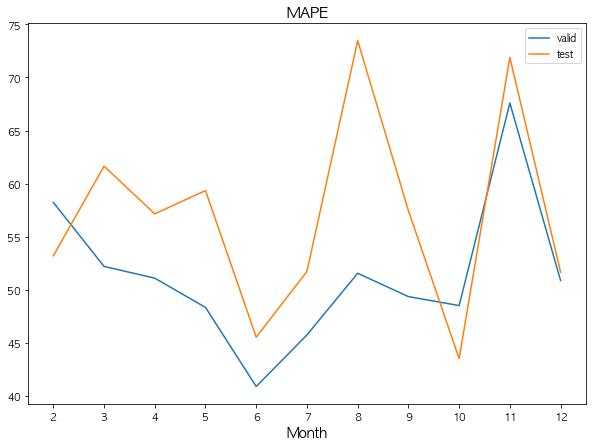

In [69]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], np.arange(2,13))
plt.show()

# 전체

In [84]:
def xgb_model(X, y):
    val_preds = []
    test_preds = []
    fe_info = dict()
    for k in X.columns:
        fe_info[k] = 0

    for i in range(1,13):
        # 한달에서도 랜덤 샘플 반 뽑기
        train_idx = X.loc[X['방송월'] != i].index
        test_idx = X.loc[X['방송월'] == i].index
        
        x_train = X.loc[train_idx]
        y_train = y.loc[x_train.index]
        
        test = X.loc[test_idx]
        x_val = test.loc[((test['방송일'] > 0) & (test['방송일'] < 8)) | ((test['방송일'] > 15) & (test['방송일'] < 24))]
        y_val = y.loc[x_val.index]
        x_test = test.loc[((test['방송일'] > 7) & (test['방송일'] < 16)) | ((test['방송일'] > 23) & (test['방송일'] < 32))]
        y_test = y.loc[x_test.index]

        dtrain = xgb.DMatrix(x_train, label = y_train)
        dvalid = xgb.DMatrix(x_val, label = y_val)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds=200, verbose_eval=10)
        for k, v in model.get_fscore().items():
            fe_info[k] += v

        dtest = xgb.DMatrix(x_test)
        val_pred = model.predict(dvalid)
        y_pred = model.predict(dtest)

        val_preds.append(MAPE(np.exp(y_val), np.exp(val_pred)))
        test_preds.append(MAPE(np.exp(y_test), np.exp(y_pred)))
        for m, arg in enumerate(zip(val_preds, test_preds), 1):
            print(f'{m}월\t', '[val]:', arg[0], '\t[test]', arg[1])
        
    return val_preds, test_preds, fe_info

In [85]:
val_preds, test_preds, fe_info2 = xgb_model(X, np.log(y))

[0]	train-rmse:15.5954	valid-rmse:15.6789
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[10]	train-rmse:11.5141	valid-rmse:11.5852
[20]	train-rmse:8.50681	valid-rmse:8.57138
[30]	train-rmse:6.291	valid-rmse:6.35702
[40]	train-rmse:4.65907	valid-rmse:4.72443
[50]	train-rmse:3.4582	valid-rmse:3.52774
[60]	train-rmse:2.57491	valid-rmse:2.66076
[70]	train-rmse:1.9258	valid-rmse:2.03444
[80]	train-rmse:1.44819	valid-rmse:1.59349
[90]	train-rmse:1.09661	valid-rmse:1.28016
[100]	train-rmse:0.836243	valid-rmse:1.05699
[110]	train-rmse:0.642914	valid-rmse:0.902306
[120]	train-rmse:0.498429	valid-rmse:0.7954
[130]	train-rmse:0.390426	valid-rmse:0.720549
[140]	train-rmse:0.309572	valid-rmse:0.667458
[150]	train-rmse:0.248685	valid-rmse:0.63173
[160]	train-rmse:0.203542	valid-rmse:0.606122
[170]	train-rmse:0.16896	valid-rmse:0.589185
[180]	train-rmse:0.142586	valid-rmse:0.576821
[190]	train-rmse:0.1

In [86]:
np.mean(val_preds), np.mean(test_preds)

(46.9218697989998, 47.89016509274105)

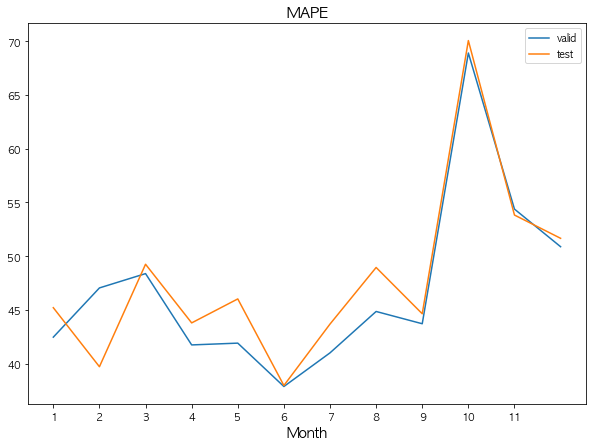

In [88]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.xticks(np.arange(0,11), np.arange(1,12))
plt.show()